In [2]:
import rebound
import numpy as np

In [3]:
'''Set-Up Initial Conditions'''
def setupSimulation():
    sim = rebound.Simulation()
    sim.integrator = 'ias15'
    sim.units = ('yr','au','solarmass')
    smass = 1.0 #in Solar Mass units
    jmass = 0.000954588 #Jupiter Mass in Solar Mass units
    delta_critical = 2.40*(np.cbrt(2.0*jmass))
    sim.add(m = smass)
    sim.add(m = jmass, a= 1, r = (0.000477895/6), f = 0, hash="planet1")
    sim.add(m = jmass, a= ((1 + delta_critical))-0.0115, r = (0.000477895/6), f = np.pi, hash="planet2")
    sim.move_to_com()
    return sim

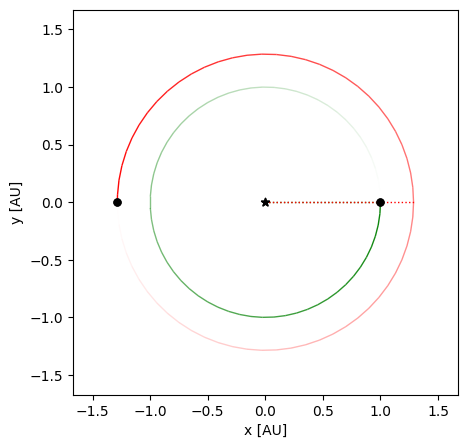

In [4]:
'''Conditions before collision'''
sim = setupSimulation()
tmax = 1e3
fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True)

In [23]:
'''Collision Resolve Function to count the number of close encounters'''
def close_encounter(sim_pointer, collision):
    global count
    global temp
    sim = sim_pointer.contents
    temp = temp + 1
    count = np.append(count, temp)
    return 0

In [24]:
sim = setupSimulation()
temp = 0
count = np.array([0])
sim.collision = "direct"
sim.collision_resolve = close_encounter
sim.integrate(tmax)
print(f"Number of Close Encounters: {count}")

Number of Close Encounters: [     0      1      2 ... 134548 134549 134550]


In [25]:
def my_merge(sim_pointer, collided_particles_index):
    global simulation_time
    sim = sim_pointer.contents 
    ps = sim.particles 
    i = collided_particles_index.p1  
    j = collided_particles_index.p2 

    simulation_time = sim.t
    print(f"First Collision Occurs at time: {simulation_time} yr")
    total_mass = ps[i].m + ps[j].m
    merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass 
    merged_radius = (ps[i].r**3 + ps[j].r**3)**(1/3)

    ps[i] = merged_planet   
    ps[i].m = total_mass    
    ps[i].r = merged_radius 
    
    return 2

In [26]:
'''Merge Condition'''
sim = setupSimulation()
sim.collision = 'direct'
sim.collision_resolve = my_merge
sim.integrate(tmax)

First Collision Occurs at time: 976.7689373044602 yr


Eccentricity of Orbit 1: 0.3017217296097025
True Anomaly of Orbit 1: 3.559327964930933
Argument of Peripasis of Orbit 1: 4.554789376866037
SMA of Orbit 1: 187.9386804934797 solar radii
Eccentricity of Orbit 2: 0.16013236170257178
True Anomaly of Orbit 2: 0.6999793166806452
Argument of Peripasis of Orbit 2: 1.2907871897348127
SMA of Orbit 2: 340.8456367291001 solar radii


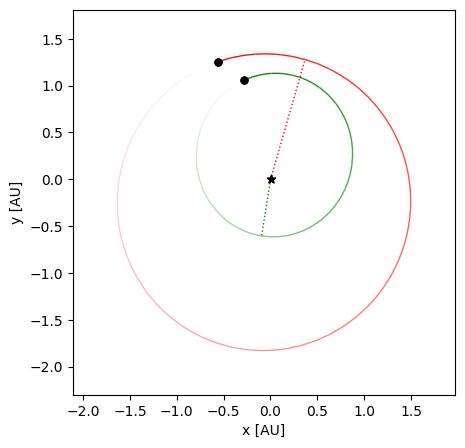

In [5]:
sim = setupSimulation()
sim.integrate(1500)
fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True)
print(f'Eccentricity of Orbit 1: {sim.calculate_orbits()[0].e}')
print(f'True Anomaly of Orbit 1: {sim.calculate_orbits()[0].f}')
print(f'Argument of Peripasis of Orbit 1: {sim.calculate_orbits()[0].omega}')
print(f'SMA of Orbit 1: {215.032*sim.calculate_orbits()[0].a} solar radii')
print(f'Eccentricity of Orbit 2: {sim.calculate_orbits()[1].e}')
print(f'True Anomaly of Orbit 2: {sim.calculate_orbits()[1].f}')
print(f'Argument of Peripasis of Orbit 2: {sim.calculate_orbits()[1].omega}')
print(f'SMA of Orbit 2: {215.032*sim.calculate_orbits()[1].a} solar radii')

In [35]:
sim.status()

---------------------------------
REBOUND version:     	3.25.1
REBOUND built on:    	Jul  2 2023 23:05:55
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	9.7675999999999999e+02
Current timestep:    	0.000501
---------------------------------
<rebound.particle.Particle object at 0x7f838fe4cfc0, m=1.0 x=0.0019886899819345043 y=-0.0010507850794956263 z=0.0 vx=0.005085880336963675 vy=0.009573939254915731 vz=0.0>
<rebound.particle.Particle object at 0x7f838fe4d3c0, m=0.000954588 x=-1.0288999740918705 y=0.5453145257097447 z=0.0 vx=-3.512648915238468 vy=-4.64459611993214 vz=0.0>
<rebound.particle.Particle object at 0x7f838fe4cfc0, m=0.000954588 x=-1.0543966752923823 y=0.5554588754994216 z=0.0 vx=-1.8151787307865186 vy=-5.384797979842534 vz=0.0>
---------------------------------


In [28]:
sim = setupSimulation()
sim.convert_particle_units('cm', 's', 'g')
print(sim.angular_momentum()[2])

1.8045835638022496e+50


$$|\vec{L}| = \mu \sqrt{2 G (M_1 + M_2) r_{p}}$$